# Batch Helpers

A notebook to help manage batch results

In [2]:
# Imports

import os
import logging
from pathlib import Path
import lbm_caiman_python as lcp

import dask.array as da
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import zarr

import lbm_mc as mc
from lbm_mc.caiman_extensions.cnmf import cnmf_cache
from caiman.source_extraction.cnmf import cnmf, params

if os.name == "nt":
    # disable the cache on windows, this will be automatic in a future version
    cnmf_cache.set_maxsize(0)

pd.options.display.max_colwidth = 120

# set up logging
debug = True

logger = logging.getLogger("caiman")
logger.setLevel(logging.DEBUG)
handler = logging.StreamHandler()
log_format = logging.Formatter("%(relativeCreated)12d [%(filename)s:%(funcName)10s():%(lineno)s] [%(process)d] %(message)s")
handler.setFormatter(log_format)
logger.addHandler(handler)

if debug:
   logging.getLogger("caiman").setLevel(logging.WARNING)

## Manage batch and dataframe filepath locations

In [ ]:
parent_path = Path().home() / "caiman_data"
data_path = parent_path / 'out'  # where the output files from the assembly step are located
batch_path = data_path / 'batch.pickle'

mc.set_parent_raw_data_path(data_path)

df=mc.load_batch(batch_path)
df.head()

algo      item_name input_movie_path  \
0  mcorr          mcorr    plane_10.tiff   
1  mcorr   plane_1.tiff     plane_1.tiff   
2  mcorr  plane_11.tiff    plane_11.tiff   
3  mcorr  plane_12.tiff    plane_12.tiff   
4  mcorr  plane_13.tiff    plane_13.tiff   

                                                                                                                    params  \
0  {'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (2, 2), 'strides': (12, 12), 'overlaps': (6, 6), 'max_dev...   
1  {'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (2, 2), 'strides': (12, 12), 'overlaps': (6, 6), 'max_dev...   
2  {'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (2, 2), 'strides': (12, 12), 'overlaps': (6, 6), 'max_dev...   
3  {'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (2, 2), 'strides': (12, 12), 'overlaps': (6, 6), 'max_dev...   
4  {'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (2, 2), 'strides': (12, 12), 'overlaps': (6, 6), 'max_dev...   

                                                                                                                   outputs  \
0  {'mean-projection-path': d2323217-2056-4681-9656-2ddebc721ac4\d2323217-2056-4681-9656-2ddebc721ac4_mean_projection.n...   
1  {'mean-projection-path': 61304ca6-5926-40ee-a769-77cc7baef155\61304ca6-5926-40ee-a769-77cc7baef155_mean_projection.n...   
2  {'mean-projection-path': f8e52582-bdbc-40cd-aeee-b21742053d3e\f8e52582-bdbc-40cd-aeee-b21742053d3e_mean_projection.n...   
3  {'mean-projection-path': 4879bb5f-b35f-4f83-83f3-5fe74515bcae\4879bb5f-b35f-4f83-83f3-5fe74515bcae_mean_projection.n...   
4  {'mean-projection-path': d7a820f6-3838-4faf-9e1d-25a5caa9345d\d7a820f6-3838-4faf-9e1d-25a5caa9345d_mean_projection.n...   

            added_time             ran_time algo_duration comments  \
0  2024-12-06T12:49:01  2024-12-06T12:57:02    248.16 sec     None   
1  2024-12-06T14:59:55  2024-12-06T15:04:08     246.5 sec     None   
2  2024-12-06T14:59:55  2024-12-06T15:08:19    250.41 sec     None   
3  2024-12-06T14:59:55  2024-12-06T15:12:31    252.04 sec     None   
4  2024-12-06T14:59:55  2024-12-06T15:16:44    252.66 sec     None   

                                   uuid  
0  d2323217-2056-4681-9656-2ddebc721ac4  
1  61304ca6-5926-40ee-a769-77cc7baef155  
2  f8e52582-bdbc-40cd-aeee-b21742053d3e  
3  4879bb5f-b35f-4f83-83f3-5fe74515bcae  
4  d7a820f6-3838-4faf-9e1d-25a5caa9345d

: 

## Remove rows with no output (accidental entries)

In [6]:
for i, row in df.iterrows():
    if row['outputs'] is None:
        df.caiman.remove_item(row.uuid)

df = df.caiman.reload_from_disk()
df

algo item_name input_movie_path  \
0  mcorr     mcorr    plane_10.tiff   

                                                                                                                    params  \
0  {'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (32, 32), 'strides': (64, 64), 'overlaps': (32, 32), 'max...   

                                                                                                                   outputs  \
0  {'mean-projection-path': 2bfd5a28-202a-426d-b74b-02105ea885a5\2bfd5a28-202a-426d-b74b-02105ea885a5_mean_projection.n...   

            added_time             ran_time algo_duration comments  \
0  2024-12-06T10:59:47  2024-12-06T11:01:36     105.4 sec     None   

                                   uuid  
0  2bfd5a28-202a-426d-b74b-02105ea885a5

## Selectively remove rows by index

Create a list of indices to remove. You can do this manually

Some useful ways to create a list:

```{code-block} python
# 0, 1 .... 30
good_rows = np.arange(0, 31) # includes 0, does not include 31

# np.concatenate is usefull to skip rows
good_rows = np.concatenate(([0, 1], np.arange(10, 30))) # 0, 1, 10 ... 29
```

In [ ]:
good_rows = [0, 1, 2]
rows_keep = [df.iloc[n].uuid for n in good_rows]
for i, row in df.iterrows():
    if row.uuid not in rows_keep:
        df.caiman.remove_item(row.uuid)

df = df.caiman.reload_from_disk()
df

## Add a `comment`

In [13]:
comment_row = 0

## Add comments to dataframe
df.iloc[comment_row].comments = "Motion correction round 1!"
df

algo          item_name  \
0  mcorr  extracted_plane_1   
1   cnmf             cnmf_1   
2   cnmf  extracted_plane_1   
3   cnmf  extracted_plane_1   
4   cnmf  extracted_plane_1   
5   cnmf  extracted_plane_1   

                                                                                                          input_movie_path  \
0                                                                                               tiff\extracted_plane_1.tif   
1  b32f41bf-a9a5-4965-be7c-e6779e854328\b32f41bf-a9a5-4965-be7c-e6779e854328-extracted_plane_1_els__d1_583_d2_536_d3_1_...   
2  b32f41bf-a9a5-4965-be7c-e6779e854328\b32f41bf-a9a5-4965-be7c-e6779e854328-extracted_plane_1_els__d1_583_d2_536_d3_1_...   
3  b32f41bf-a9a5-4965-be7c-e6779e854328\b32f41bf-a9a5-4965-be7c-e6779e854328-extracted_plane_1_els__d1_583_d2_536_d3_1_...   
4  b32f41bf-a9a5-4965-be7c-e6779e854328\b32f41bf-a9a5-4965-be7c-e6779e854328-extracted_plane_1_els__d1_583_d2_536_d3_1_...   
5  b32f41bf-a9a5-4965-be7c-e6779e854328\b32f41bf-a9a5-4965-be7c-e6779e854328-extracted_plane_1_els__d1_583_d2_536_d3_1_...   

                                                                                                                    params  \
0  {'main': {'var_name_hdf5': 'mov', 'max_shifts': (10, 10), 'strides': (48, 48), 'overlaps': (24, 24), 'max_deviation_...   
1  {'main': {'fr': 9.62, 'dxy': (1.0, 1.0), 'decay_time': 0.4, 'strides': (48, 48), 'overlaps': (24, 24), 'max_shifts':...   
2  {'main': {'fr': 9.62, 'dxy': (1.0, 1.0), 'decay_time': 0.4, 'strides': (48, 48), 'overlaps': (24, 24), 'max_shifts':...   
3  {'main': {'fr': 9.62, 'dxy': (1.0, 1.0), 'decay_time': 0.4, 'strides': (48, 48), 'overlaps': (24, 24), 'max_shifts':...   
4  {'main': {'fr': 9.62, 'dxy': (1.0, 1.0), 'decay_time': 0.4, 'strides': (48, 48), 'overlaps': (24, 24), 'max_shifts':...   
5  {'main': {'fr': 9.62, 'dxy': (1.0, 1.0), 'decay_time': 0.4, 'strides': (48, 48), 'overlaps': (24, 24), 'max_shifts':...   

                                                                                                                   outputs  \
0  {'mean-projection-path': b32f41bf-a9a5-4965-be7c-e6779e854328\b32f41bf-a9a5-4965-be7c-e6779e854328_mean_projection.n...   
1  {'mean-projection-path': a057e39e-a2df-41d3-8217-83c9cd7ffb6d\a057e39e-a2df-41d3-8217-83c9cd7ffb6d_mean_projection.n...   
2  {'mean-projection-path': 5cb543ec-5358-4b35-83cf-bfd19fa06a68\5cb543ec-5358-4b35-83cf-bfd19fa06a68_mean_projection.n...   
3  {'mean-projection-path': df52a609-d986-4bc0-a0a2-526cbfda057d\df52a609-d986-4bc0-a0a2-526cbfda057d_mean_projection.n...   
4  {'mean-projection-path': b68a8efe-1a3b-4392-b6e7-416312f1f945\b68a8efe-1a3b-4392-b6e7-416312f1f945_mean_projection.n...   
5  {'mean-projection-path': 15e6fb81-fac4-457b-96da-dbb8e2d7b669\15e6fb81-fac4-457b-96da-dbb8e2d7b669_mean_projection.n...   

            added_time             ran_time algo_duration  \
0  2024-09-26T11:56:54  2024-09-26T12:02:55      77.3 sec   
1  2024-09-26T16:26:20  2024-09-26T16:28:48    143.18 sec   
2  2024-09-27T14:48:59  2024-09-27T14:50:30     80.14 sec   
3  2024-09-27T14:48:59  2024-09-27T14:51:46     75.93 sec   
4  2024-09-27T14:48:59  2024-09-30T10:30:15     96.62 sec   
5  2024-09-27T14:48:59  2024-09-30T10:20:28    109.54 sec   

                     comments                                  uuid  
0  Motion correction round 1!  b32f41bf-a9a5-4965-be7c-e6779e854328  
1                        None  a057e39e-a2df-41d3-8217-83c9cd7ffb6d  
2                        None  5cb543ec-5358-4b35-83cf-bfd19fa06a68  
3                        None  df52a609-d986-4bc0-a0a2-526cbfda057d  
4                        None  b68a8efe-1a3b-4392-b6e7-416312f1f945  
5                        None  15e6fb81-fac4-457b-96da-dbb8e2d7b669

## Change the `item_name`

In [ ]:
comment_row = 0

## Add comments to dataframe
df.iloc[comment_row].item_name = "Motion correction round 1!"
df

## Change/correct `input_movie_path`

- for example, add .zarr ext to directory for caiman compatibility

In [ ]:
## Correct filenames
for idx, row in df.iterrows():
    row.input_movie_path = Path(row.input_movie_path).with_suffix('.zarr')
df.caiman.save_to_disk()

## Convert intermediate `.mmmap` to `.zarr`

TODO: Move these to a separate 'helpers' notebook as they aren't related specifically to batch management

In [8]:
res_path = movie_path.parent / 'registered'
res_path.mkdir(exist_ok=True)
store = zarr.open_like(mcorr_movie, path=res_path, mode='a',)  # read/write, create if it doesnt exist
store[:] = mcorr_movie

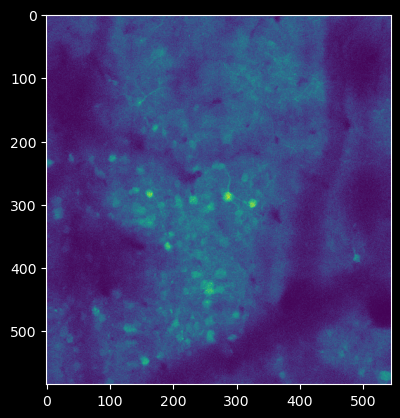

In [10]:
plt.imshow(store[1, :,:])